In [1]:
from astropy.io import fits
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import resample

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

%matplotlib inline

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
data = fits.open('data_lt_sprat/v_a_20190516_57_1_0_1.fits')[0].data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


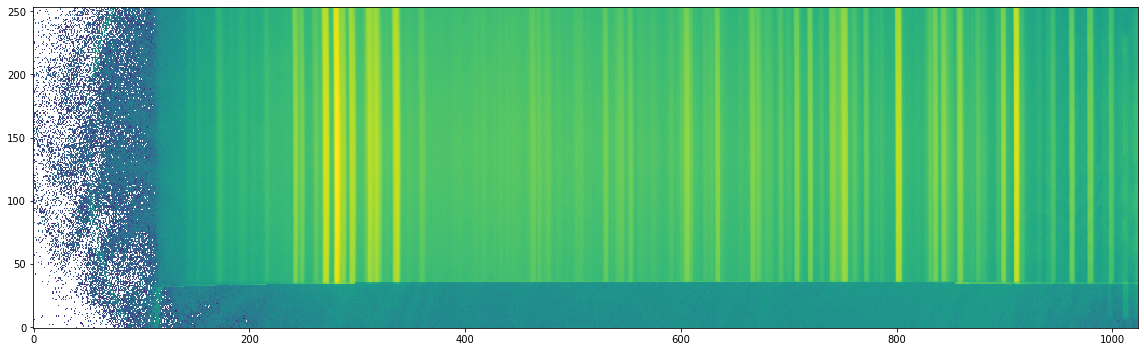

In [3]:
plt.figure(1, figsize=(16,5))
plt.imshow(np.log(data.data), aspect='auto', origin='lower')
plt.tight_layout()

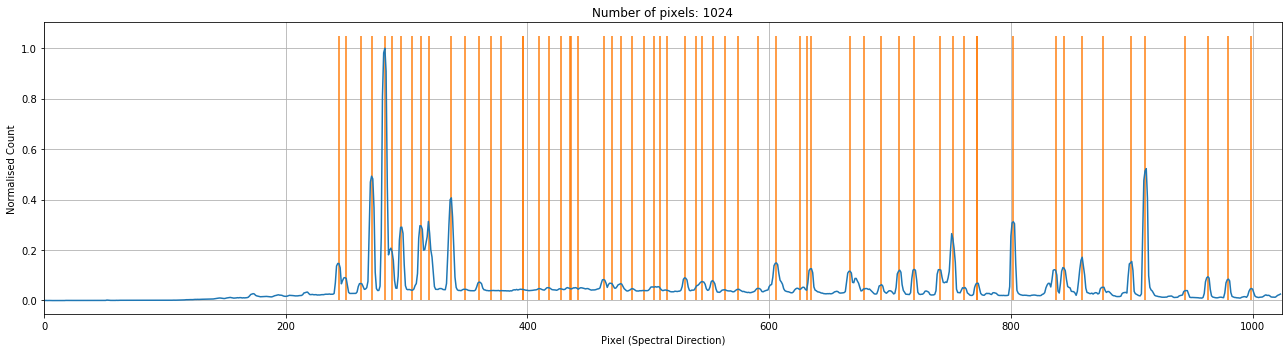

In [4]:
spectrum = np.median(data[110:120], axis=0)

peaks, _ = find_peaks(spectrum, height=500, distance=5, threshold=None)
peaks = refine_peaks(spectrum, peaks, window_width=5)

plt.figure(figsize=(18,5))
plt.plot(spectrum / spectrum.max())
plt.vlines(peaks, 0, 1.05, colors='C1')
plt.title('Number of pixels: ' + str(spectrum.shape[0]))
plt.xlabel("Pixel (Spectral Direction)")
plt.ylabel("Normalised Count")
plt.xlim(0, 1024)
plt.grid()
plt.tight_layout()

In [5]:
c = Calibrator(peaks,
               num_pix=len(spectrum),
               min_wavelength=3800.,
               max_wavelength=8200.,
               silence=True)
c.set_fit_constraints(num_slopes=10000,
                      range_tolerance=500.,
                      xbins=100,
                      ybins=100)
c.add_atlas(elements='Xe')

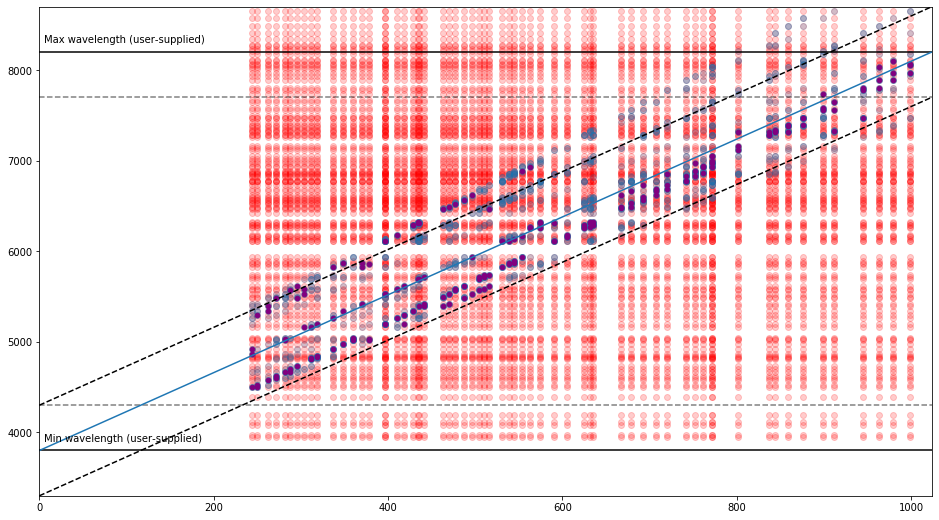

In [6]:
c.plot_search_space()

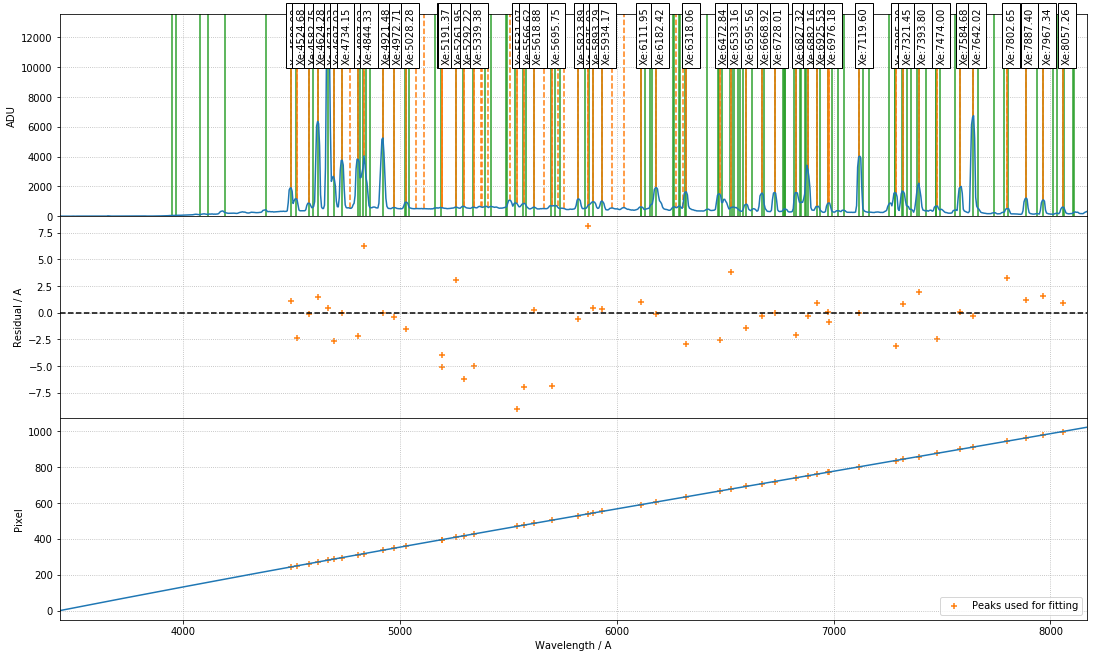

Stdev error: 0.274069298172605 A
Peaks utilisation rate: 31.746031746031743%


In [7]:
final_tolerance = 9.2

best_p, rms, residual, peak_utilisation = c.fit(max_tries=10000)

c.plot_fit(spectrum, best_p, plot_atlas=True, log_spectrum=False, tolerance=final_tolerance, renderer='notebook')

rms = np.sqrt(np.sum(residual**2 / len(residual)))

print("Stdev error: {} A".format(np.abs(residual).std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation*100))

# Now, we refine this set of polynomial coefficients and apply to a different night of arc

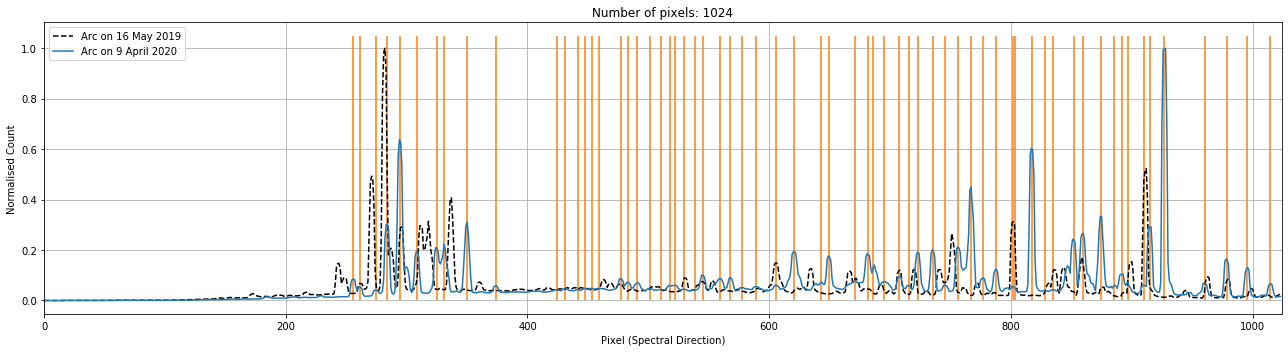

In [8]:
data2 = fits.open('data_lt_sprat/v_a_20200409_39_1_0_1.fits')[0].data
spectrum2 = np.median(data2[110:120], axis=0)

peaks2, _ = find_peaks(spectrum2, height=500, distance=5, threshold=None)
peaks2 = refine_peaks(spectrum2, peaks2, window_width=3)

plt.figure(figsize=(18,5))
plt.plot(spectrum / spectrum.max(), ls="--", color='black', label='Arc on 16 May 2019')
plt.plot(spectrum2 / spectrum2.max(), label='Arc on 9 April 2020')
plt.vlines(peaks2, 0, 1.05, colors='C1')
plt.title('Number of pixels: ' + str(spectrum2.shape[0]))
plt.xlabel("Pixel (Spectral Direction)")
plt.ylabel("Normalised Count")
plt.xlim(0, 1024)
plt.legend()
plt.grid()
plt.tight_layout()

## (1) Refine the polynomial fit coefficients with robust_refit=False

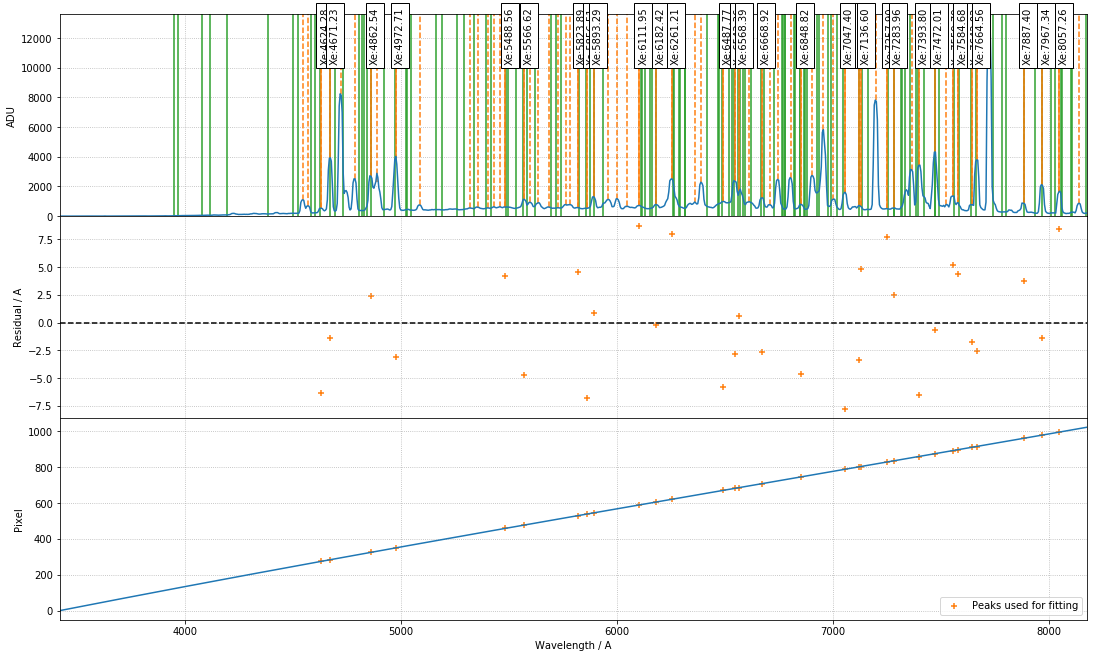

Stdev error: 5.047356594971304 A
Peaks utilisation rate: 49.23076923076923%


In [9]:
c2 = Calibrator(peaks2,
               num_pix=len(spectrum2),
               min_wavelength=3800.,
               max_wavelength=8200.,
               silence=True)
c2.set_fit_constraints(num_slopes=5000,
                      range_tolerance=500.,
                      xbins=100,
                      ybins=100)
c2.add_atlas(elements='Xe')

best_p2, x_fit2, y_fit2, residual2, peak_utilisation2 = c2.refine_fit(best_p, delta=best_p*0.01, tolerance=10., convergence=1e-10, method='Nelder-Mead', robust_refit=False)

c2.plot_fit(spectrum2, best_p2, plot_atlas=True, log_spectrum=False, tolerance=final_tolerance, renderer='notebook')

fit_diff2 = c2.polyval(x_fit2, best_p2) - y_fit2

rms2 = np.sqrt(np.sum(fit_diff2**2 / len(x_fit2)))

print("Stdev error: {} A".format(fit_diff2.std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation2*100))

## (2) Refine the polynomial fit coefficients with robust_refit=True

In [10]:
c3 = Calibrator(peaks2,
               num_pix=1024,
               min_wavelength=3800.,
               max_wavelength=8200.,
               silence=True)
c3.set_fit_constraints(num_slopes=5000,
                      range_tolerance=500.,
                      xbins=200,
                      ybins=200)
c3.add_atlas(elements='Xe')

best_p3, _, _, _, _ = c3.refine_fit(best_p, delta=best_p[:1]*0.01, tolerance=100., convergence=1e-10, method='Nelder-Mead')
best_p3, x_fit3, y_fit3, residual3, peak_utilisation3 = c3.refine_fit(best_p3, delta=best_p3*0.01, tolerance=10., convergence=1e-10, method='Nelder-Mead', robust_refit=True)


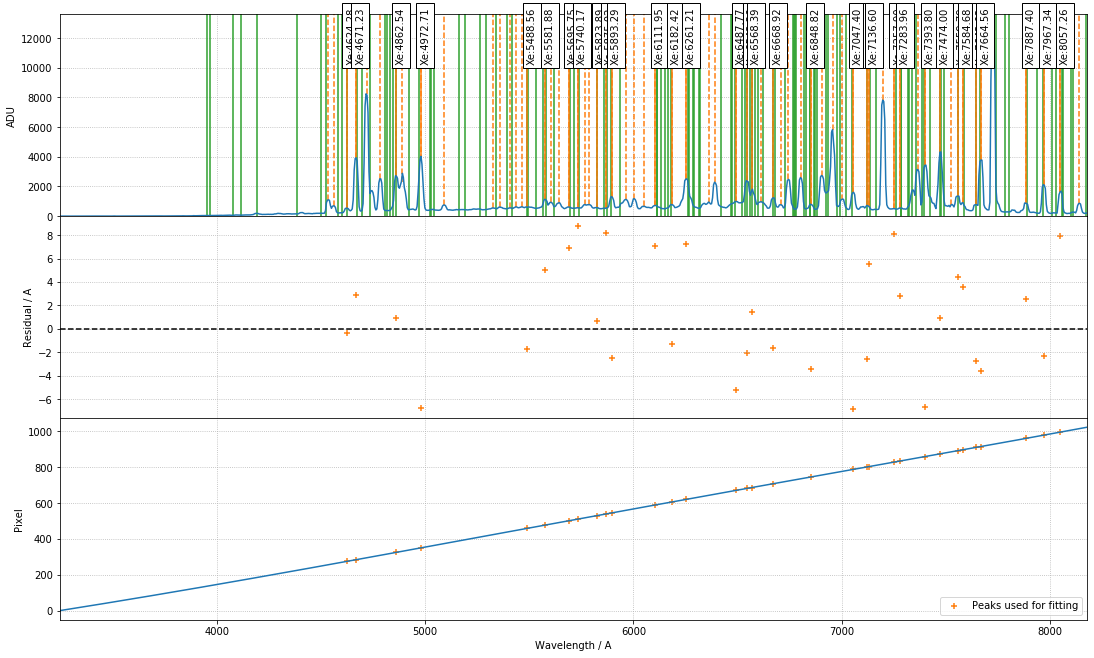

Stdev error: 4.627781018571402 A
Peaks utilisation rate: 47.69230769230769%


In [11]:
c3.plot_fit(spectrum2, best_p3, plot_atlas=True, log_spectrum=False, tolerance=final_tolerance, renderer='notebook')

fit_diff3 = c3.polyval(x_fit3, best_p3) - y_fit3

rms3 = np.sqrt(np.sum(fit_diff3**2 / len(x_fit3)))

print("Stdev error: {} A".format(fit_diff3.std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation3*100))